In [1]:
import pandas as pd
import json
import os
from tqdm import tqdm
import synthpops as sps
import numpy as np
import covasim as cv
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pylab as pl
import sciris as sc
import scipy as sp
import optuna as op
from datetime import datetime, date
import random
import time

from autocalibration_covasim.functions_total import *
import warnings
warnings.filterwarnings("ignore")

import autocalibration_covasim.calibration_total as st
from autocalibration_covasim.calibration_total import model

Covasim 3.1.6 (2024-01-28) — © 2020-2024 by IDM


# Создание популяции

### Подготовка данных

In [2]:
folder = './data/chelyabinsk_1'

schools_path = folder + '/popdata/schools.json'
people_path = folder + '/popdata/people.txt'
households_path = folder + '/popdata/households.txt'
pop_path = folder + '/population/pop_covasim.json'

In [3]:
school = json.load(open(os.path.expanduser(schools_path)))
people = pd.read_csv(people_path, sep='\t')
households = pd.read_csv(households_path, sep='\t')

### Создание словаря id: age

In [4]:
people_by_age = {}
for i in tqdm(range(101)):
    people_by_age[i]=sorted(list(people[people.age==i]['sp_id']))

  0%|          | 0/101 [00:00<?, ?it/s]

In [5]:
age_by_id = {}
for i in people_by_age:
    for j in people_by_age[i]:
        age_by_id[j]=i

### Создание списка списков жителей одного дома

In [6]:
households = []
for i in tqdm(list(people.groupby('sp_hh_id').size().index)):
    households.append(list(people[people.sp_hh_id==i]['sp_id']))

  0%|          | 0/11739 [00:00<?, ?it/s]

### Создание списка списков с учениками одной школы

In [7]:
schools = []
for i in tqdm(list(people[(people.age<18)&(people.work_id!='X')].groupby('work_id').size().index)):
    schools.append(list(people[(people.work_id==i)&(people.age<18)]['sp_id']))

  0%|          | 0/113 [00:00<?, ?it/s]

### Создание списка списков с рабочими из одного рабочего места

In [8]:
works = []
for i in tqdm(list(people[(people.age>=18)&(people.work_id!='X')].groupby('work_id').size().index)):
    works.append(list(people[(people.work_id==i)&(people.age>=18)]['sp_id']))

  0%|          | 0/10335 [00:00<?, ?it/s]

### Создание списка списков с учителями из одной школы

In [9]:
teachers = []
for i in range(len(schools)):
    teachers.append([])#schools[i][0]])
    #del schools[i][0]

### Генерация словаря популяции

In [10]:
popdict = sps.contact_networks.make_contacts(
    sps.pop.Pop, 
    age_by_uid=age_by_id, 
    homes_by_uids=households, 
    students_by_uid_lists=schools,
    workplace_by_uid_lists=works,
    teachers_by_uid_lists=teachers,
    average_class_size=100000,
)

### Конвертация в json

In [11]:
def myconverter(obj):
        if isinstance(obj, np.int64):
            return int(obj)
        if isinstance(obj, set):
            return list(obj)
        raise TypeError

In [12]:
with open(pop_path, "w", encoding="utf-8") as file:
    json.dump(popdict, file, default=myconverter)

# Загрузка популяции из json

In [39]:
pop_path = './data/chelyabinsk_1/population/pop_covasim.json'

In [40]:
jsonpop = json.load(open(os.path.expanduser(pop_path)))

popdict = {}
for i in jsonpop:
    popdict[int(i)] = jsonpop[i]
    for j in ['H', 'S', 'W', 'C']:
        popdict[int(i)]['contacts'][j] = set(jsonpop[i]['contacts'][j])

# Работа с ковасимом

### Создание симуляции с заданной популяцией

In [41]:
params_path = './data/chelyabinsk_1/params/Chelyabinsk_dataset.csv'

In [42]:
pars = {'pop_size': 40614,
 'pop_infected': 71.4701344874034,
 'pop_type': 'synthpops',
 'location': 'Chelyabinsk',
 'start_day': '2020-03-03',
 'end_day': '2020-06-01',
 'rand_seed': 1,
 'verbose': 0,
 'pop_scale': 1,
 'scaled_pop': None,
 'rescale': False,
 'rescale_threshold': 1,
 'rescale_factor': 1,
 'frac_susceptible': 0.78,
 'contacts': {'h': 1.57, 's': 8.5, 'w': 8.5, 'c': 0, 'l': 10},
 'dynam_layer': {'h': 0, 's': 0, 'w': 0, 'c': 0, 'l': 0},
 'beta_layer': {'h': 3.0, 's': 0.6, 'w': 0.6, 'c': 0.3, 'l': 1.5},
 'beta_dist': {'dist': 'neg_binomial',
  'par1': 1.0,
  'par2': 0.45,
  'step': 0.01},
 'viral_dist': {'frac_time': 0.3, 'load_ratio': 2, 'high_cap': 4},
 'beta': 0.4532533335658518,
 'asymp_factor': 1.0,
 'n_imports': 0,
 'n_variants': 1,
 'use_waning': False,

 'rel_imm_symp': {'asymp': 0.85, 'mild': 1, 'severe': 1.5},
 'immunity': None,
 'trans_redux': 0.59,
 'rel_beta': 1.0,

 'rel_symp_prob': 1.0,
 'rel_severe_prob': 1.0,
 'rel_crit_prob': 0,
 'rel_death_prob': 0,
 'prog_by_age': False,
 'prognoses': {'age_cutoffs': np.array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
      'sus_ORs':  np.array([0.34, 0.67, 1.  , 1.  , 1.  , 1.  , 1.24, 1.47, 1.47, 1.47]),
      'trans_ORs':  np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
      'comorbidities':  np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
      'symp_probs':  np.array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.9 ]),
      'severe_probs':  np.array([0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273,
             0.273]),
      'crit_probs':  np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
      'death_probs':  np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'iso_factor': {'h': 1, 's': 1, 'w': 1, 'c': 1, 'l': 1},
 'quar_factor': {'h': 1, 's': 1, 'w': 1, 'c': 1, 'l': 1},
 'quar_period': 0,
 'interventions': [cv.test_num(daily_tests=40797, symp_test=100.0, quar_test=1.0, quar_policy=None, subtarget=None, ili_prev=None, sensitivity=1.0, loss_prob=0, test_delay=0, start_day=0, end_day=None, swab_delay=None)],
 'analyzers': [],
 'timelimit': None,
 'stopping_func': None,
 'n_beds_hosp': None,
 'n_beds_icu': None,
 'no_hosp_factor': 1,
 'no_icu_factor': 1,
 'vaccine_pars': {},
 'vaccine_map': {},
 'variants': [],
 'variant_map': {0: 'wild'},
 'variant_pars': {'wild': {'rel_beta': 1.0,
   'rel_symp_prob': 1.0,
   'rel_severe_prob': 1.0,
   'rel_crit_prob': 0,
   'rel_death_prob': 0}}}

sim = cv.Sim(pars, interventions=cv.test_num(daily_tests=len(popdict)), datafile=params_path)
sim.popdict = cv.make_synthpop(sim, popdict=popdict)


### Калибровка

In [24]:
calib_pars = dict(
    beta           = [0.23451319609633497, 0.1, 0.50],
    pop_infected   = [10, 1, 100]
)
calib = sim.calibrate(calib_pars=calib_pars, total_trials=100)

Could not delete study, skipping...
'Record does not exist.'
Removed existing calibration covasim_calibration.db


[I 2024-04-20 14:25:27,249] A new study created in RDB with name: covasim_calibration
[I 2024-04-20 14:25:30,641] Trial 2 finished with value: 2426.290625851828 and parameters: {'beta': 0.23868192644696481, 'pop_infected': 79.3120793766564}. Best is trial 2 with value: 2426.290625851828.
[I 2024-04-20 14:25:30,746] Trial 0 finished with value: 2409.7801866869613 and parameters: {'beta': 0.4638855207022632, 'pop_infected': 76.51446587995555}. Best is trial 0 with value: 2409.7801866869613.
[I 2024-04-20 14:25:30,907] Trial 1 finished with value: 2482.1048807114394 and parameters: {'beta': 0.16601400083168172, 'pop_infected': 40.841547296290656}. Best is trial 0 with value: 2409.7801866869613.
[I 2024-04-20 14:25:31,170] Trial 3 finished with value: 2460.844981503376 and parameters: {'beta': 0.27698468262578313, 'pop_infected': 19.07550258832752}. Best is trial 0 with value: 2409.7801866869613.
[I 2024-04-20 14:25:31,965] Trial 10 finished with value: 2487.431734563131 and parameters: {'

Making results structure...
Processed 108 trials; 0 failed
Deleted study covasim_calibration in sqlite:///covasim_calibration.db
Removed existing calibration covasim_calibration.db
Calibration for 108 total trials completed in 40.3 s.

Initial parameter values:
#0. 'beta':         0.23451319609633497
#1. 'pop_infected': 10

Best parameter values:
#0. 'beta':         0.49831008993318593
#1. 'pop_infected': 96.41630236645493

Mismatch before calibration: 2480.87
Mismatch after calibration:  2391.1
Percent improvement:         3.6%


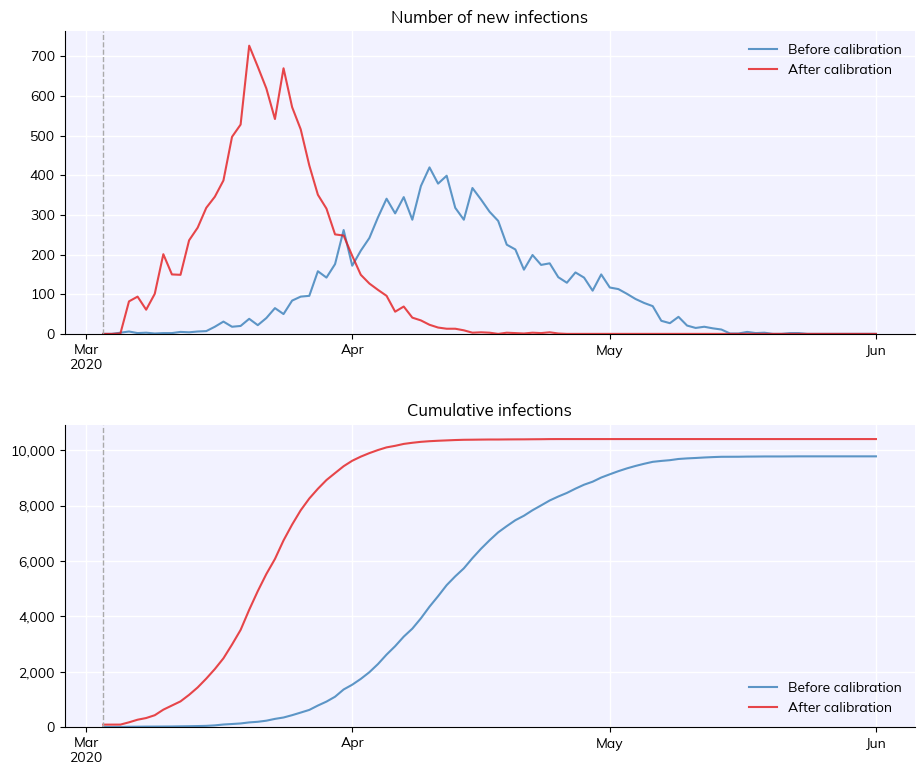

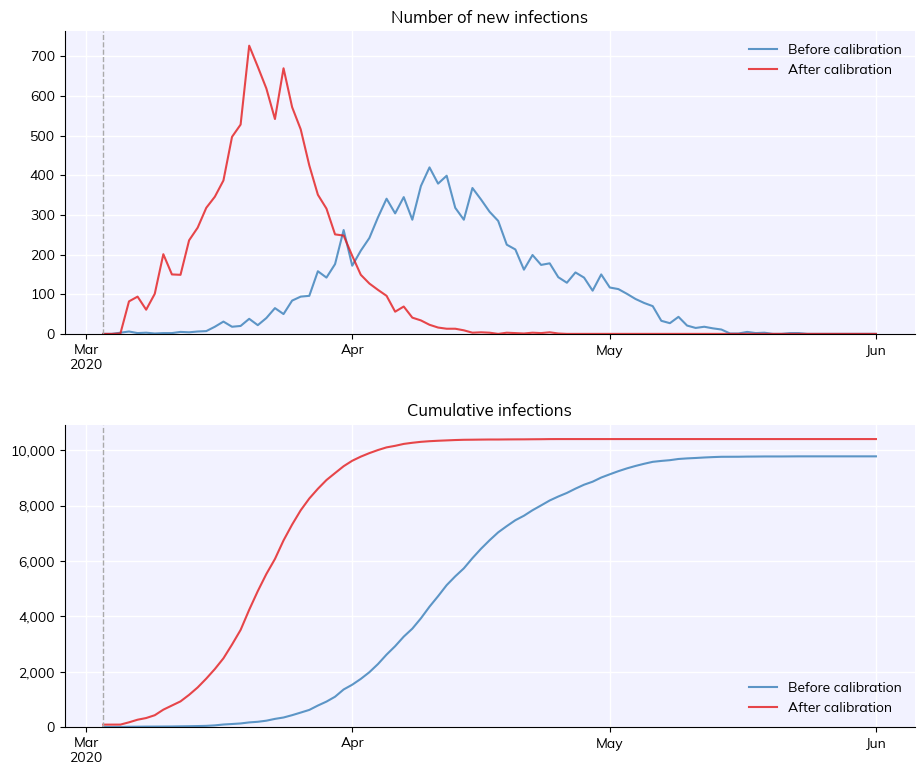

In [25]:
calib.plot_sims(to_plot=['new_infections','cum_infections'])

### Автокалибровка

In [28]:
location='Chelyabinsk'
pop_location=40614
cal_keys=['n_infectious', 'new_diagnoses', 'cum_diagnoses'] # ключи для калибровки
cal_values=[1, 2, 3] # веса для параметров
pop_inf=[98,1,150] # количество первоначально зараженных: лучшее, мин, макс

data_csv=params_path


df1=pd.read_csv(data_csv,index_col=0,parse_dates=True)

# fill unknown tests
df1.new_tests=past_extr(df=df1,series=df1.new_tests,n=df1['new_tests'].isna().sum())
df1=smooth_pd(df1)
df1['date']=df1.index

# define start day and last day, bounds_of_periods for calibration
start_day=cv.date(df1.index[0].to_pydatetime().date())
last_day=cv.date(df1.index[-1].to_pydatetime().date())
bounds_of_periods=bounds_of_per(start_day,last_day)
bounds_of_periods.append(cv.date(last_day, as_date=False))
                         
# parameters for plotting
figsize=(18,5)
fontsize=18
fontsize_legend=15
linewidth=2
ticks=50
rotation=0
dateformat='%Y.%m.%d'

In [29]:
# import calibrated parameters for Novosibirsk
calibrated_path = './data/chelyabinsk_1/params/p_autocal_total.json'
calibrated_params=open(calibrated_path,'r')
p=json.load(calibrated_params)


# define beta_changes and beta_days from calibrated parameters in list 'p'
b_days=[]
b_changes=[]
for i in range(len(p)):
    b_days.append(p[i][f'beta_day_{i+1}'])
    b_changes.append(p[i][f'beta_change_{i+1}'])
b_days=list(map(int, b_days))


# dates of beta_change
b_change_model=cv.date(b_days,start_date=start_day, as_date=False)

p before calibration []
Modeling  2020-03-03  -  2020-04-02
Running initial uncalibrated simulation...


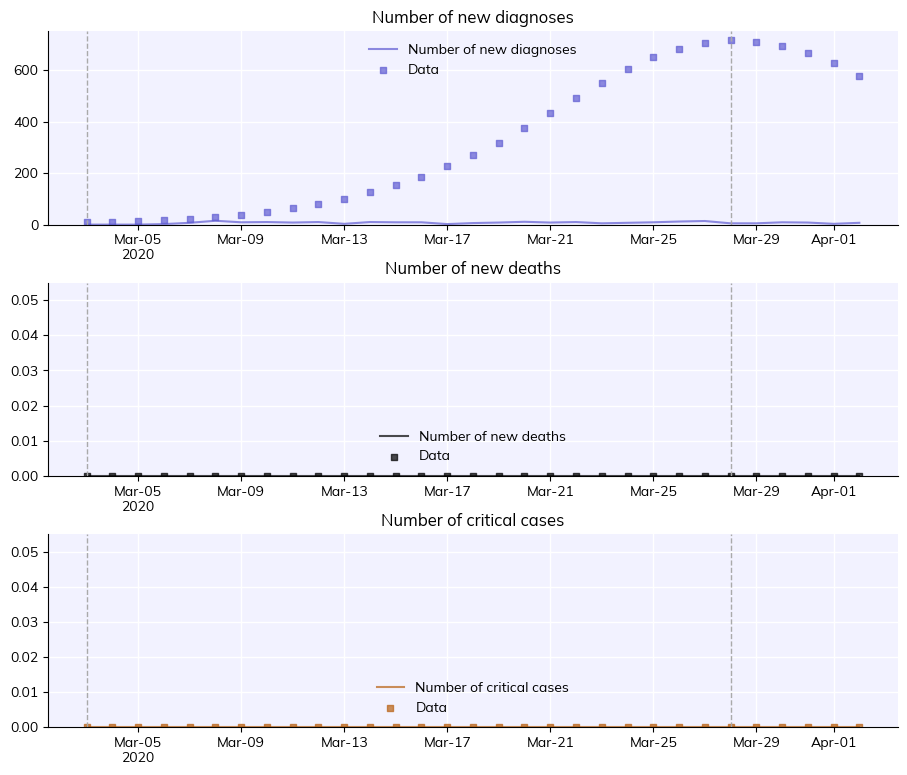

<Figure size 640x480 with 0 Axes>

Starting calibration for Novosibirsk


[I 2024-04-20 14:28:14,221] A new study created in RDB with name: covasim
[I 2024-04-20 14:28:19,460] Trial 0 finished with value: 67.09486731220152 and parameters: {'pop_infected': 8.035477896910852, 'beta': 0.010195726579506487, 'beta_day': 29.088738730518624, 'beta_change': 1.1398824419452804, 'symp_test': 46.36549393714823}. Best is trial 0 with value: 67.09486731220152.
[I 2024-04-20 14:28:24,483] Trial 1 finished with value: 66.01650307795606 and parameters: {'pop_infected': 36.41365903656446, 'beta': 0.022667118627476723, 'beta_day': 4.589164927805005, 'beta_change': 1.1485169101484836, 'symp_test': 121.27190716694396}. Best is trial 1 with value: 66.01650307795606.
[I 2024-04-20 14:28:29,234] Trial 2 finished with value: 66.9418613413323 and parameters: {'pop_infected': 19.371568659051103, 'beta': 0.01440618907350157, 'beta_day': 13.514432006800586, 'beta_change': 0.5113207247896661, 'symp_test': 110.18401292167901}. Best is trial 1 with value: 66.01650307795606.
[I 2024-04-20 

Mismatch: 62.687069217500095
Elapsed time: 505 s
Plotting result...


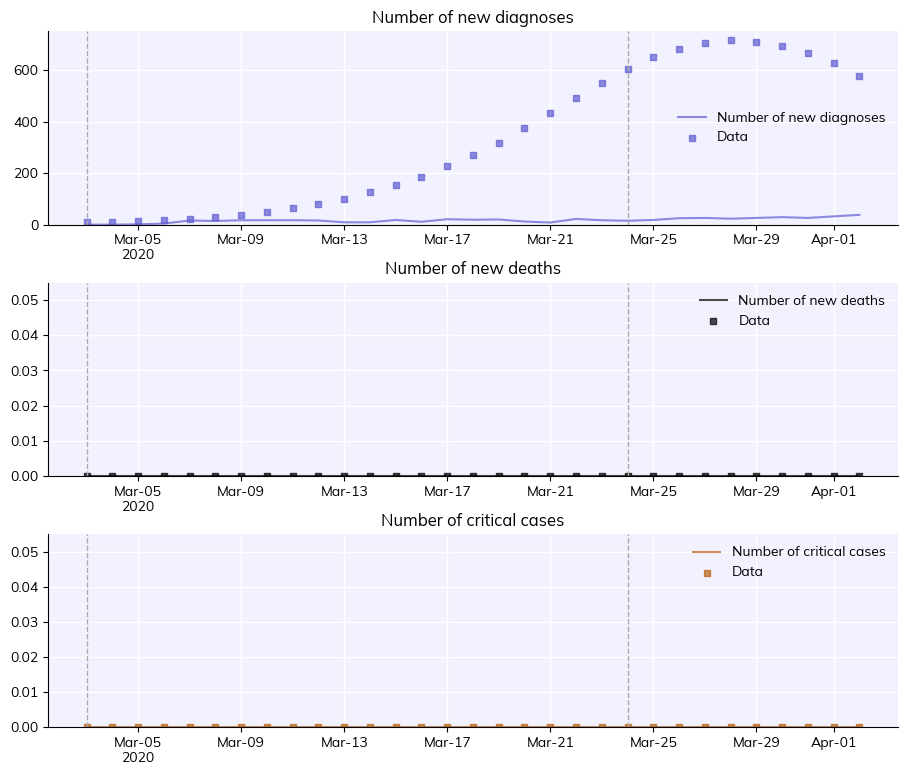

p after calibration [{'pop_infected': 146.43880492754798, 'beta': 0.02498566499060102, 'symp_test': 87.10141076591972, 'beta_change_1': 1.1802427664267128, 'beta_day_1': 21.657986130488155}]
p before calibration [{'pop_infected': 146.43880492754798, 'beta': 0.02498566499060102, 'symp_test': 87.10141076591972, 'beta_change_1': 1.1802427664267128, 'beta_day_1': 21.657986130488155}]
Modeling  2020-03-03  -  2020-05-02
Running initial uncalibrated simulation...


<Figure size 640x480 with 0 Axes>

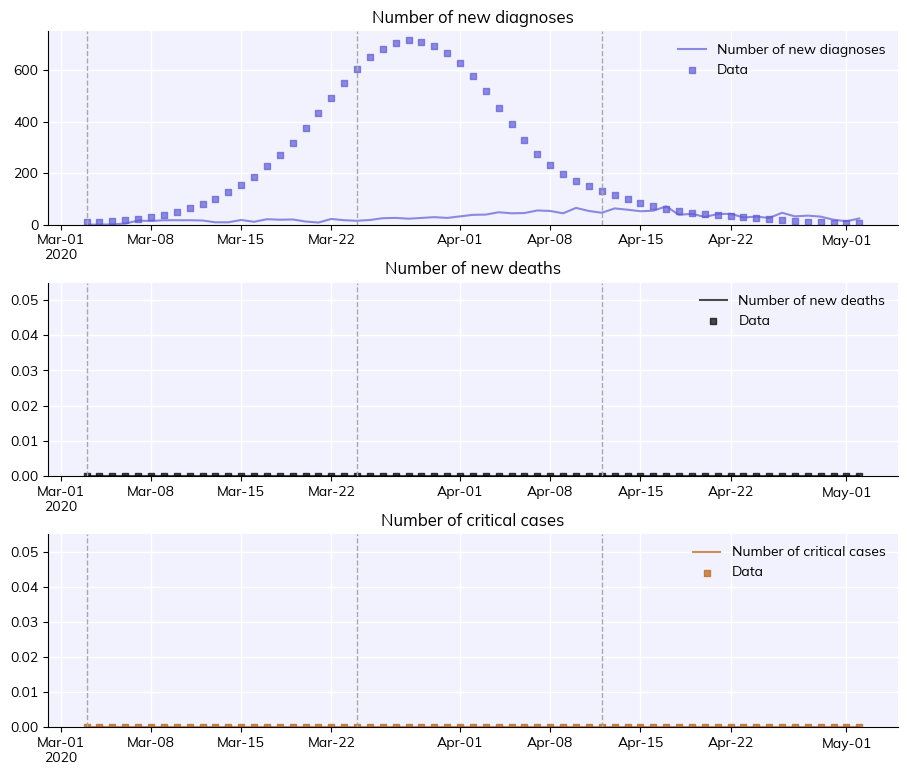

<Figure size 640x480 with 0 Axes>

Starting calibration for Novosibirsk


[I 2024-04-20 14:36:53,074] A new study created in RDB with name: covasim
[I 2024-04-20 14:36:58,686] Trial 0 finished with value: 152.6877755869158 and parameters: {'beta_day': 24.287491776183025, 'beta_change': 0.5659220878712201}. Best is trial 0 with value: 152.6877755869158.
[I 2024-04-20 14:37:03,708] Trial 1 finished with value: 149.61660051546335 and parameters: {'beta_day': 42.32201728403359, 'beta_change': 0.9376020324471925}. Best is trial 1 with value: 149.61660051546335.
[I 2024-04-20 14:37:08,695] Trial 2 finished with value: 149.72933991701046 and parameters: {'beta_day': 52.94670393964161, 'beta_change': 0.34098160286968865}. Best is trial 1 with value: 149.61660051546335.
[I 2024-04-20 14:37:14,025] Trial 3 finished with value: 150.16844162247514 and parameters: {'beta_day': 55.40690971667266, 'beta_change': 0.38564696303140533}. Best is trial 1 with value: 149.61660051546335.
[I 2024-04-20 14:37:18,956] Trial 4 finished with value: 150.81434846023166 and parameters: {

Mismatch: 148.09544973678825
Elapsed time: 529 s
Plotting result...


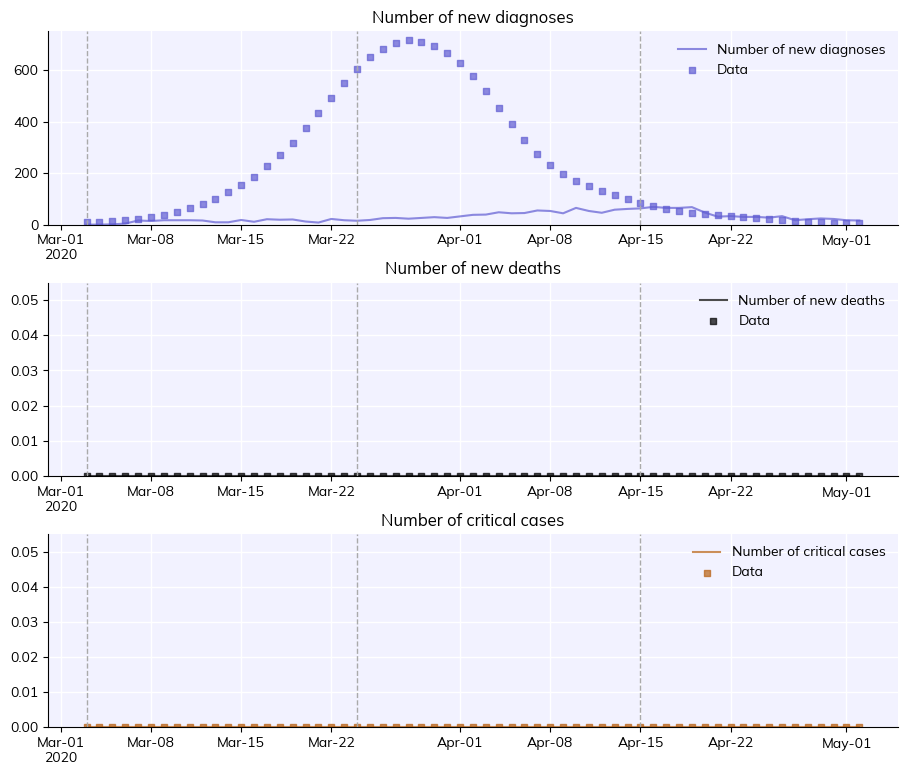

p after calibration [{'pop_infected': 146.43880492754798, 'beta': 0.02498566499060102, 'symp_test': 87.10141076591972, 'beta_change_1': 1.1802427664267128, 'beta_day_1': 21.657986130488155}, {'beta_change_2': 0.3165163311708702, 'beta_day_2': 43.35507154155226}]
p before calibration [{'pop_infected': 146.43880492754798, 'beta': 0.02498566499060102, 'symp_test': 87.10141076591972, 'beta_change_1': 1.1802427664267128, 'beta_day_1': 21.657986130488155}, {'beta_change_2': 0.3165163311708702, 'beta_day_2': 43.35507154155226}]
Modeling  2020-03-03  -  2020-06-01
Running initial uncalibrated simulation...


<Figure size 640x480 with 0 Axes>

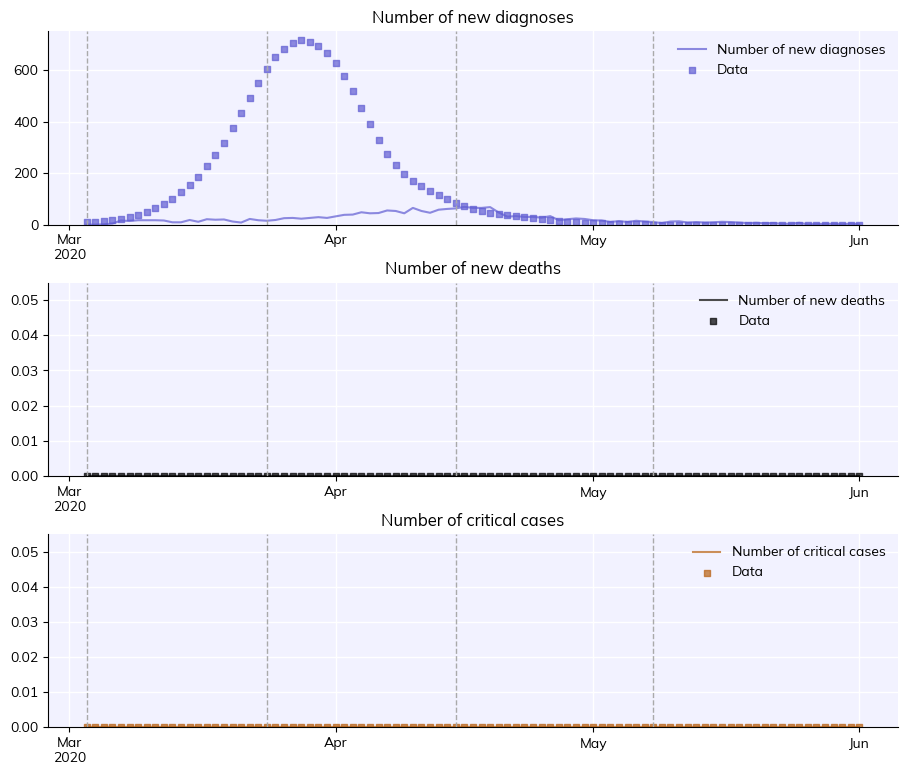

<Figure size 640x480 with 0 Axes>

Starting calibration for Novosibirsk


[I 2024-04-20 14:45:57,220] A new study created in RDB with name: covasim
[I 2024-04-20 14:46:02,846] Trial 0 finished with value: 227.27291622907464 and parameters: {'beta_day': 88.00444500878037, 'beta_change': 0.9449676650337282}. Best is trial 0 with value: 227.27291622907464.
[I 2024-04-20 14:46:08,157] Trial 1 finished with value: 227.3969079945686 and parameters: {'beta_day': 47.79062832134971, 'beta_change': 0.5053369418980074}. Best is trial 0 with value: 227.27291622907464.
[I 2024-04-20 14:46:13,462] Trial 2 finished with value: 228.25540393793372 and parameters: {'beta_day': 53.442552595503436, 'beta_change': 0.7286554466744841}. Best is trial 0 with value: 227.27291622907464.
[I 2024-04-20 14:46:18,840] Trial 3 finished with value: 227.27291622907464 and parameters: {'beta_day': 88.94908396313986, 'beta_change': 1.0759005328016957}. Best is trial 0 with value: 227.27291622907464.
[I 2024-04-20 14:46:24,040] Trial 4 finished with value: 227.355460968165 and parameters: {'be

Mismatch: 226.95545318314726
Elapsed time: 557 s
Plotting result...


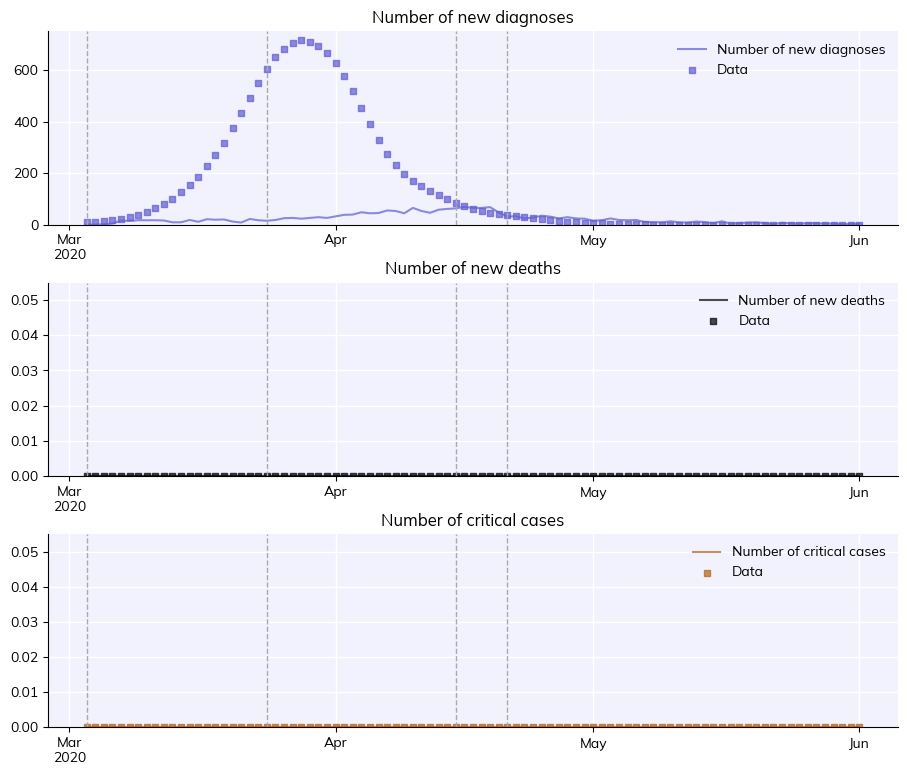

p after calibration [{'pop_infected': 146.43880492754798, 'beta': 0.02498566499060102, 'symp_test': 87.10141076591972, 'beta_change_1': 1.1802427664267128, 'beta_day_1': 21.657986130488155}, {'beta_change_2': 0.3165163311708702, 'beta_day_2': 43.35507154155226}, {'beta_change_3': 0.4026879231461531, 'beta_day_3': 49.00781045266774}]
p before calibration [{'pop_infected': 146.43880492754798, 'beta': 0.02498566499060102, 'symp_test': 87.10141076591972, 'beta_change_1': 1.1802427664267128, 'beta_day_1': 21.657986130488155}, {'beta_change_2': 0.3165163311708702, 'beta_day_2': 43.35507154155226}, {'beta_change_3': 0.4026879231461531, 'beta_day_3': 49.00781045266774}]
Modeling  2020-03-03  -  2020-06-01
Running initial uncalibrated simulation...


<Figure size 640x480 with 0 Axes>

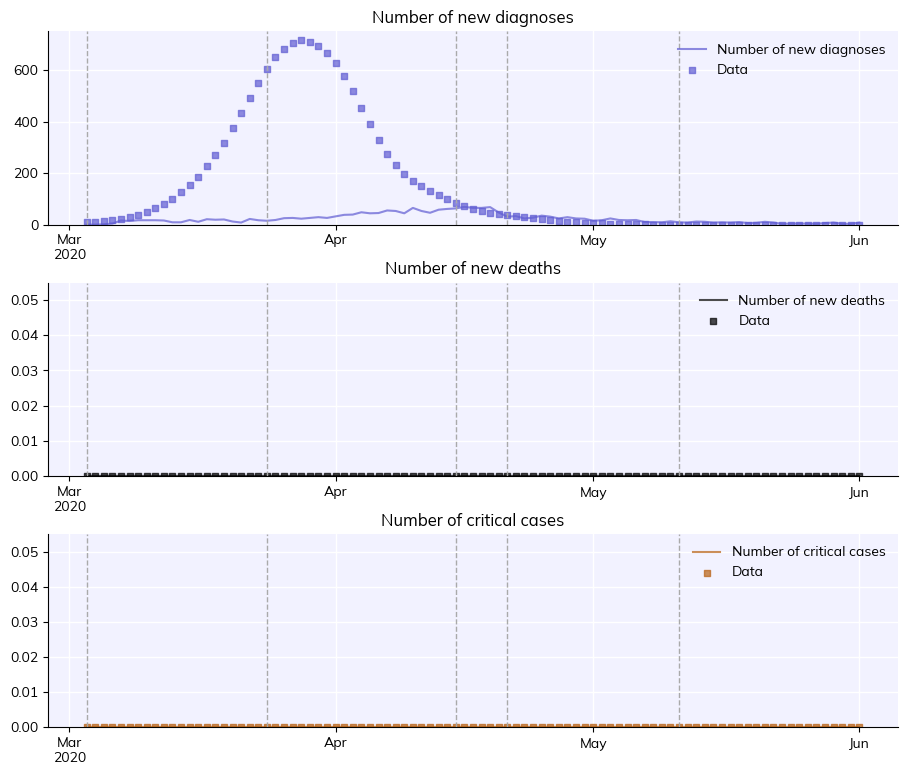

<Figure size 640x480 with 0 Axes>

Starting calibration for Novosibirsk


[I 2024-04-20 14:55:29,981] A new study created in RDB with name: covasim
[I 2024-04-20 14:55:35,522] Trial 0 finished with value: 227.03170934694504 and parameters: {'beta_day': 82.67278966519109, 'beta_change': 1.0341424073180576}. Best is trial 0 with value: 227.03170934694504.
[I 2024-04-20 14:55:41,194] Trial 1 finished with value: 227.84765269939996 and parameters: {'beta_day': 58.69177625886192, 'beta_change': 0.7929850234132909}. Best is trial 0 with value: 227.03170934694504.
[I 2024-04-20 14:55:46,483] Trial 2 finished with value: 227.32988307416525 and parameters: {'beta_day': 56.55977932986402, 'beta_change': 0.46646870731629275}. Best is trial 0 with value: 227.03170934694504.
[I 2024-04-20 14:55:51,775] Trial 3 finished with value: 226.90096301544298 and parameters: {'beta_day': 67.05045781971198, 'beta_change': 0.30025423695715764}. Best is trial 3 with value: 226.90096301544298.
[I 2024-04-20 14:55:57,137] Trial 4 finished with value: 227.25009071885518 and parameters: 

Mismatch: 226.77696646146947
Elapsed time: 539 s
Plotting result...


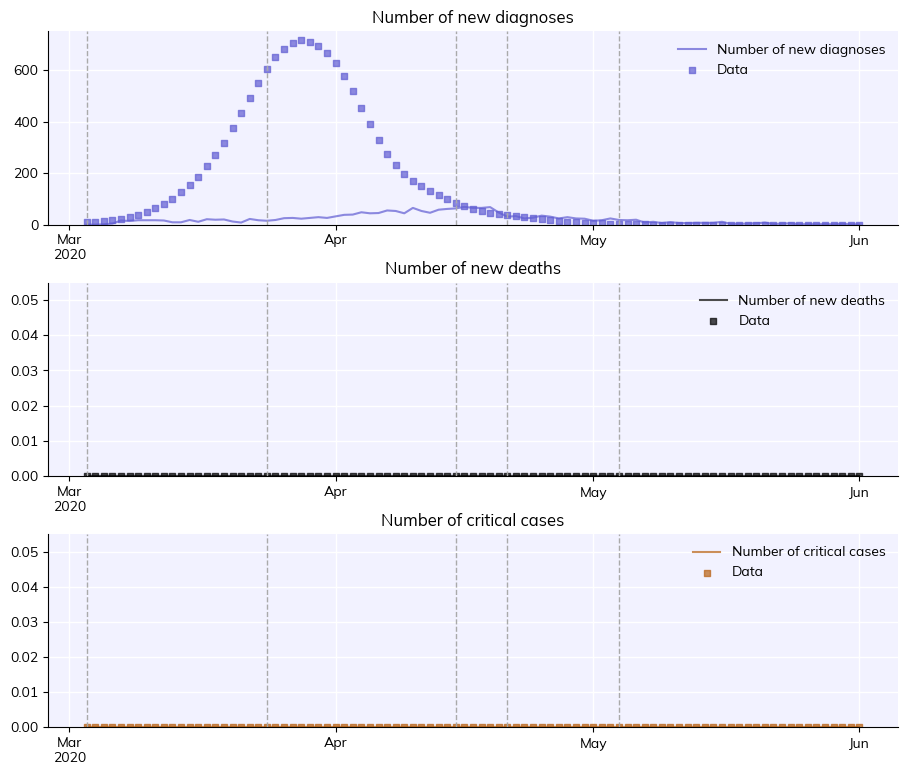

p after calibration [{'pop_infected': 146.43880492754798, 'beta': 0.02498566499060102, 'symp_test': 87.10141076591972, 'beta_change_1': 1.1802427664267128, 'beta_day_1': 21.657986130488155}, {'beta_change_2': 0.3165163311708702, 'beta_day_2': 43.35507154155226}, {'beta_change_3': 0.4026879231461531, 'beta_day_3': 49.00781045266774}, {'beta_change_4': 0.3000809653857563, 'beta_day_4': 62.301094300551625}]


In [30]:
# do autocalibration

# create an empty list for calibrated parameters
p=[]

for i in range(len(bounds_of_periods)):
    print('p before calibration', p)
    sim,p=calibration_process(param=p, datafile=df1, location=location, pop_location=pop_location, start_day=start_day,
                              end_day=bounds_of_periods[i], cal_keys=cal_keys, cal_values=cal_values, pop_inf=pop_inf,
                              #n_runs=n_runs, n_workers=n_workers,
                              popdict=popdict)
    print('p after calibration', p)

with open(calibrated_path, 'w') as jsonfile:
    json.dump(p, jsonfile)

In [ ]:
sim=run_model(p=p, location=location, pop_location=pop_location, start_day=start_day, end_day=last_day, 
              b_days=b_days, b_changes=b_changes, data=df1, run=False, popdict=popdict)
namesim=''
# run multiple sims to calculate confidential interval
run_msim_conf(sim=sim, to_plot=['new_diagnoses'], save=True, namemsim=namesim)

#### Нужна ли новая калибровка

In [ ]:
previous_cal_day='2021-01-17' #день начала калибровки
timedelt = 40 # период рекалибровки
previous_cal_day, day_today, run_calibration=if_new_calib(previous_cal_day=previous_cal_day, timedelt=timedelt)

if run_calibration:
    sim,p = calibration_process(param=p, datafile=df1, location=location, pop_location=pop_location, start_day=start_day,
                              end_day=day_today, cal_keys=cal_keys, cal_values=cal_values, pop_inf=pop_inf,
                              school_days=school_days, school_changes=school_changes)
    sim=run_model(p=p, end_day=day_today,location=location, pop_location=pop_location, start_day=start_day, school_days=school_days, school_changes=school_changes, 
                 b_days=b_days, b_changes=b_changes, data=df1,run=True)
else: 
    sim=run_model(p=p, end_day=day_today,location=location, pop_location=pop_location, start_day=start_day, school_days=school_days, school_changes=school_changes, 
                 b_days=b_days, b_changes=b_changes, data=df1,run=True)
    
#sim.plot(to_plot=['new_diagnoses','new_infections'],show_args={'interventions':False})

#### Доверительный интервал

In [ ]:
sim=run_model(p=p, location=location, pop_location=pop_location, start_day=start_day, end_day=last_day, 
              b_days=b_days, b_changes=b_changes, data=df1, run=False, popdict=popdict)
namesim='Chelyabinsk_25'
# run multiple sims to calculate confidential interval
run_msim_conf(sim=sim, to_plot=['new_diagnoses'], save=True, namemsim=namesim)

In [ ]:
# detailed plot of confidential interval
msi_path = "" # путь до файла с симуляцией
msi=cv.load(msi_path) 
dday=80
test_data=None


msi.plot(to_plot=['new_diagnoses'],fig_args={'figsize': figsize},test_data=test_data)
msi.plot(to_plot=['new_diagnoses'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['new_deaths'],fig_args={'figsize': figsize},test_data=test_data)
msi.plot(to_plot=['new_deaths'],fig_args={'figsize': figsize},dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['new_recoveries'],fig_args={'figsize': figsize}, test_data=test_data)
msi.plot(to_plot=['new_recoveries'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)
msi.plot(to_plot=['n_critical'],fig_args={'figsize': figsize}, test_data=test_data)
msi.plot(to_plot=['n_critical'],fig_args={'figsize': figsize}, dday=dday, test_data=test_data, dateformat=dateformat)

### Моделирование

In [43]:
sim.run()

Sim(<no label>; 2020-03-03 to 2020-06-01; pop: 40614 synthpops; epi: 10332⚙, 0☠)

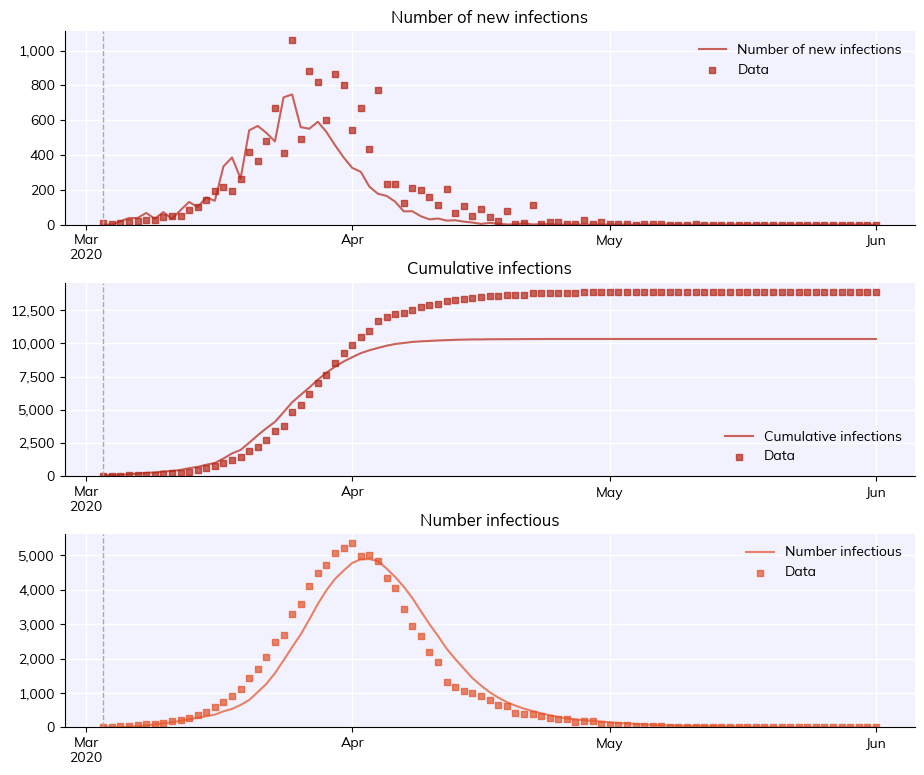

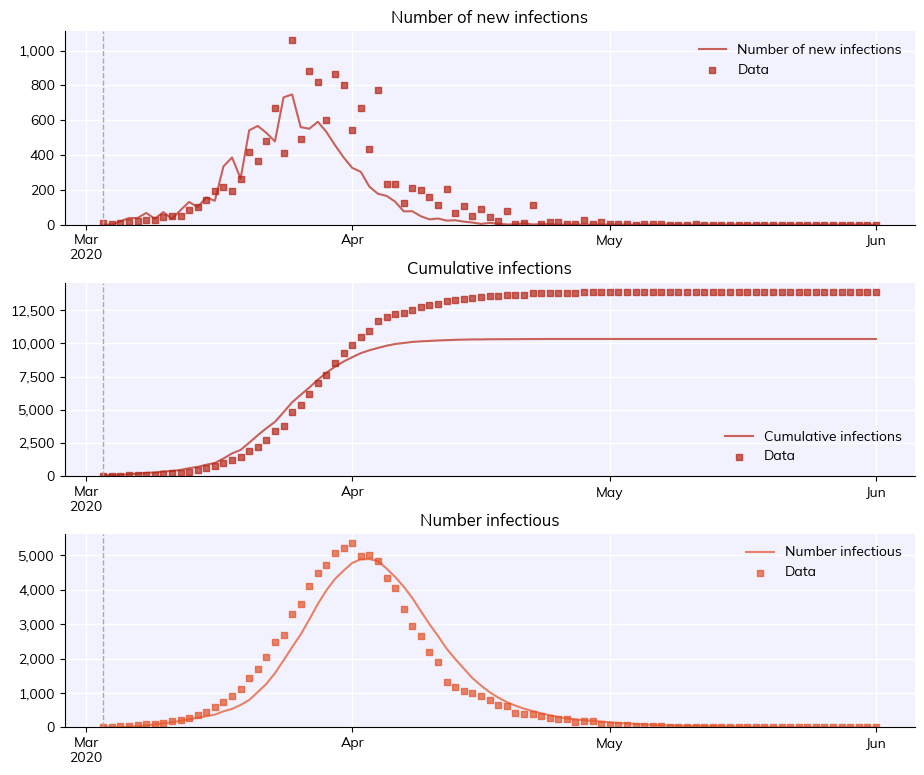

In [44]:
sim.plot(to_plot=['new_infections','cum_infections', 'n_infectious'])

In [ ]:
fit = sim.compute_fit()
fit.summarize()

In [ ]:
fit.plot()
fit.summarize()

### Параметры популяции

In [ ]:
sim.people.plot()